# Кластеризация отзывов о винах

1. Подготовка данных: убрать пропуски и дубликаты; определиться с выбором столбцов.
2. Выбор алгоритмов кластеризации: K-means и DBSCAN.

In [1]:
# Загрузка нужных библиотек

# imports here
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#viz
import seaborn as sns
import matplotlib.pyplot as plt

# progress bar
from tqdm import tqdm

In [2]:
# открытие датасета

data = pd.read_csv('/content/winemag-data-130k-v2.csv')

In [3]:
print(data.shape)
data.head(5)

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
# Параметры в датасете:
data.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [5]:
data = data[['country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery']]

# Проверка
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
from pandas.errors import PyperclipWindowsException
# функция для изучения данных датафрейма
def open_info(data):
    # вывод 5 строк данных
    print('*******************************************************')
    print('Представление датафрейма')
    display(data.head(3))
    print('*******************************************************')
    # вывод информации о датафрейме
    print('Общая информация о датафрейме')
    print('')
    print(data.info())
    print('*******************************************************')
    # вывод информации о распределении данных
    print('Распределение данных')
    print(data.describe())
    print('*******************************************************')
    # проверка на наличие пропусков
    print('Пропуски:', data.isna().sum().sum())
    print('*******************************************************')
    print('Наличие пропусков по столбцам')
    print(data.isna().any())
    print('*******************************************************')
    # проверка на наличие дубликатов
    print('Дубликаты:', data.duplicated().sum())

In [7]:
open_info(data)

*******************************************************
Представление датафрейма


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes:

Из 14 столбцов в 9 есть пропуски. В некоторых случаях можно убрать строки с пропусками, потому что их мало. Например, столбы, в которых процент пропусков не превышает 15 процентов. В некоторых случаях удалим сам столбец, потому что в нем много пропусков. Еще в датафрейме есть дубликаты, которые нужно удалить.

In [8]:
# удаление столбцов с пропусками
data = data[['country', 'description', 'points', 'price', 'province', 'title', 'variety', 'winery']]

# удаление пропусков
data = data.dropna()

# удаление дубликатов
data = data.drop_duplicates()

# Проверка
data.isna().sum()

country        0
description    0
points         0
price          0
province       0
title          0
variety        0
winery         0
dtype: int64

Теперь датасет состоит из 8 столбцов. Однако стоит еще проверить выбросы в данных.

<Axes: >

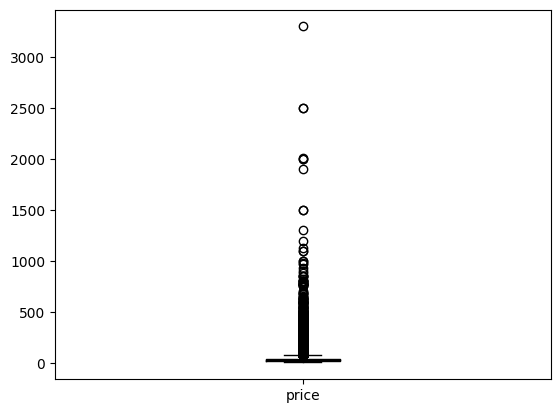

In [9]:
# Построение boxplot с использованием matplotlib
data.boxplot(column=['price'], grid= False , color='black')

Видим, что есть выбросы в столбце "price", от которых лучше избавиться.

<Axes: >

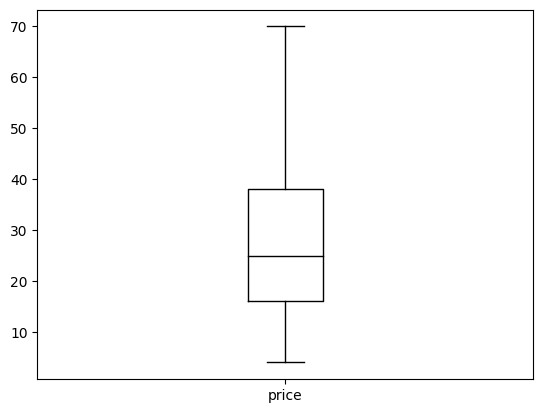

In [10]:
# Избавляемся от выбросов
data = data.loc[data['price'] <= 70]

# Проверка
data.boxplot(column=['price'], grid= False , color='black')

In [11]:
data.shape

(102744, 8)

## Подготовка данных

Векторизуем все столбцы с текстовыми данными.

Столбец "description"

In [12]:
# приведем все к нижнему регистру
data["text"] = data.description.apply(lambda x: x.lower().split())

input_text = list(data.text.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['this', 'is', 'a', 'dry', 'wine,', 'very', 'spicy,', 'with', 'a', 'tight,', 'taut', 'texture', 'and', 'strongly', 'mineral', 'character', 'layered', 'with', 'citrus', 'as', 'well', 'as', 'pepper.', "it's", 'a', 'food', 'wine', 'with', 'its', 'almost', 'crisp', 'aftertaste.'], tags=[10]),
 TaggedDocument(words=['slightly', 'reduced,', 'this', 'wine', 'offers', 'a', 'chalky,', 'tannic', 'backbone', 'to', 'an', 'otherwise', 'juicy', 'explosion', 'of', 'rich', 'black', 'cherry,', 'the', 'whole', 'accented', 'throughout', 'by', 'firm', 'oak', 'and', 'cigar', 'box.'], tags=[11])]

In [13]:
model = Doc2Vec(documents, vector_size=3, window=2, min_count=1, workers=4)

In [14]:
model.save("D2V.model") # сохранение модели

In [15]:
# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

In [16]:
# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v1', 'v2', 'v3'])

split_df

,v1,v2,v3
0,-0.451741,-0.291334,0.245471
1,0.220101,0.114876,0.145273
2,-0.377987,-0.243634,0.013967
3,-0.053946,0.208975,0.357093
4,-0.145754,-0.021139,0.372767
...,...,...,...
102739,-0.158422,-0.323104,0.253698
102740,0.000142,-0.088372,0.220720
102741,-0.317823,0.291538,0.298063
102742,-0.333906,-0.093073,0.439400


In [17]:
# теперь добавим его к основному датафрейму
result = data.join(split_df, how='left')
result.shape

(102744, 12)

In [18]:
result = result.dropna()
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
dtypes: float32(3), float64(1), int64(1), object(7)
memory usage: 7.3+ MB


Столбец "province"

In [19]:
# приведем все к нижнему регистру
data["text_2"] = data.province.apply(lambda x: x.lower().split())

input_text = list(data.text_2.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['alsace'], tags=[10]),
 TaggedDocument(words=['california'], tags=[11])]

In [20]:
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

In [21]:
# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v4'])

split_df

,v4
0,-0.484195
1,-0.597913
2,-0.802465
3,0.872766
4,0.420594
...,...
102739,0.975900
102740,-0.331284
102741,0.051289
102742,0.187471


In [22]:
# теперь добавим его к основному датафрейму
result_new = result.join(split_df, how='left')
result_new.shape

(82776, 13)

In [23]:
result_new = result_new.dropna()
result_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
 12  v4           82776 non-null  float32
dtypes: float32(4), float64(1), int64(1), object(7)
memory usage: 9.6+ MB


Столбец "title"

In [24]:
# приведем все к нижнему регистру
data["text_3"] = data.title.apply(lambda x: x.lower().split())

input_text = list(data.text_3.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['leon', 'beyer', '2012', 'gewurztraminer', '(alsace)'], tags=[10]),
 TaggedDocument(words=['louis', 'm.', 'martini', '2012', 'cabernet', 'sauvignon', '(alexander', 'valley)'], tags=[11])]

In [25]:
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v5'])

split_df

,v5
0,-0.359012
1,-0.513579
2,-0.856110
3,0.904362
4,0.607266
...,...
102739,1.198224
102740,-0.280686
102741,0.194195
102742,0.282262


In [26]:
# теперь добавим его к основному датафрейму
result = result_new.join(split_df, how='left')
result.shape

(82776, 14)

In [27]:
result = result.dropna()
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
 12  v4           82776 non-null  float32
 13  v5           82776 non-null  float32
dtypes: float32(5), float64(1), int64(1), object(7)
memory usage: 9.9+ MB


Столбец "variety"

In [28]:
# приведем все к нижнему регистру
data["text_4"] = data.variety.apply(lambda x: x.lower().split())

input_text = list(data.text_4.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['gewürztraminer'], tags=[10]),
 TaggedDocument(words=['cabernet', 'sauvignon'], tags=[11])]

In [29]:
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v6'])

split_df

,v6
0,-0.479677
1,-0.542545
2,-0.961994
3,0.863163
4,0.473385
...,...
102739,1.013709
102740,-0.404422
102741,0.115388
102742,0.265701


In [30]:
# теперь добавим его к основному датафрейму
result_new = result.join(split_df, how='left')
result_new.shape

(82776, 15)

In [31]:
result_new = result_new.dropna()
result_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
 12  v4           82776 non-null  float32
 13  v5           82776 non-null  float32
 14  v6           82776 non-null  float32
dtypes: float32(6), float64(1), int64(1), object(7)
memory usage: 10.2+ MB


Столбец "winery"

In [32]:
# приведем все к нижнему регистру
data["text_5"] = data.winery.apply(lambda x: x.lower().split())

input_text = list(data.text_5.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['leon', 'beyer'], tags=[10]),
 TaggedDocument(words=['louis', 'm.', 'martini'], tags=[11])]

In [33]:
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v7'])

split_df

,v7
0,-0.412784
1,-0.507820
2,-0.896681
3,0.942527
4,0.400528
...,...
102739,1.008313
102740,-0.287750
102741,0.073073
102742,0.278104


In [34]:
# теперь добавим его к основному датафрейму
result = result_new.join(split_df, how='left')
result.shape

(82776, 16)

In [35]:
result = result.dropna()
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
 12  v4           82776 non-null  float32
 13  v5           82776 non-null  float32
 14  v6           82776 non-null  float32
 15  v7           82776 non-null  float32
dtypes: float32(7), float64(1), int64(1), object(7)
memory usage: 10.5+ MB


Столбец "country"

In [36]:
# приведем все к нижнему регистру
data["text_6"] = data.country.apply(lambda x: x.lower().split())

input_text = list(data.text_6.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]
documents[10:12]

[TaggedDocument(words=['france'], tags=[10]),
 TaggedDocument(words=['us'], tags=[11])]

In [37]:
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4)

# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# так получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v8'])

split_df

,v8
0,-0.510230
1,-0.589903
2,-0.988075
3,0.864520
4,0.356612
...,...
102739,0.976934
102740,-0.405075
102741,0.017003
102742,0.177307


In [38]:
# теперь добавим его к основному датафрейму
result = result.join(split_df, how='left')
result.shape

(82776, 17)

In [39]:
result = result.dropna()
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82776 entries, 1 to 102743
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      82776 non-null  object 
 1   description  82776 non-null  object 
 2   points       82776 non-null  int64  
 3   price        82776 non-null  float64
 4   province     82776 non-null  object 
 5   title        82776 non-null  object 
 6   variety      82776 non-null  object 
 7   winery       82776 non-null  object 
 8   text         82776 non-null  object 
 9   v1           82776 non-null  float32
 10  v2           82776 non-null  float32
 11  v3           82776 non-null  float32
 12  v4           82776 non-null  float32
 13  v5           82776 non-null  float32
 14  v6           82776 non-null  float32
 15  v7           82776 non-null  float32
 16  v8           82776 non-null  float32
dtypes: float32(8), float64(1), int64(1), object(7)
memory usage: 10.9+ MB


In [40]:
# переопределим датасет, оставив только важное

data_sm = result[['points', 'price', "v1","v2","v3","v4","v5",'v6', 'v7', 'v8']]

data_sm.head(3)

,points,price,v1,v2,v3,v4,v5,v6,v7,v8
1,87,15.0,0.220101,0.114876,0.145273,-0.597913,-0.513579,-0.542545,-0.507820,-0.589903
2,87,14.0,-0.377987,-0.243634,0.013967,-0.802465,-0.856110,-0.961994,-0.896681,-0.988075
3,87,13.0,-0.053946,0.208975,0.357093,0.872766,0.904362,0.863163,0.942527,0.864520


In [41]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
data_scaled=data_sm.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

In [42]:
data_scaled.head(3)

,points,price,v1,v2,v3,v4,v5,v6,v7,v8
1,-0.377258,-0.876031,1.597450,0.392163,-0.693135,-1.131081,-1.144204,-1.046095,-1.050781,-1.037973
2,-0.377258,-0.942429,-1.238718,-1.130462,-1.333213,-1.492401,-1.770569,-1.788625,-1.746478,-1.729456
3,-0.377258,-1.008827,0.297905,0.791809,0.339422,1.466715,1.448697,1.442360,1.543984,1.487834


Получен датафрейм с 10 столбцами. Проверим корреляцию между ними и соотношение данных.

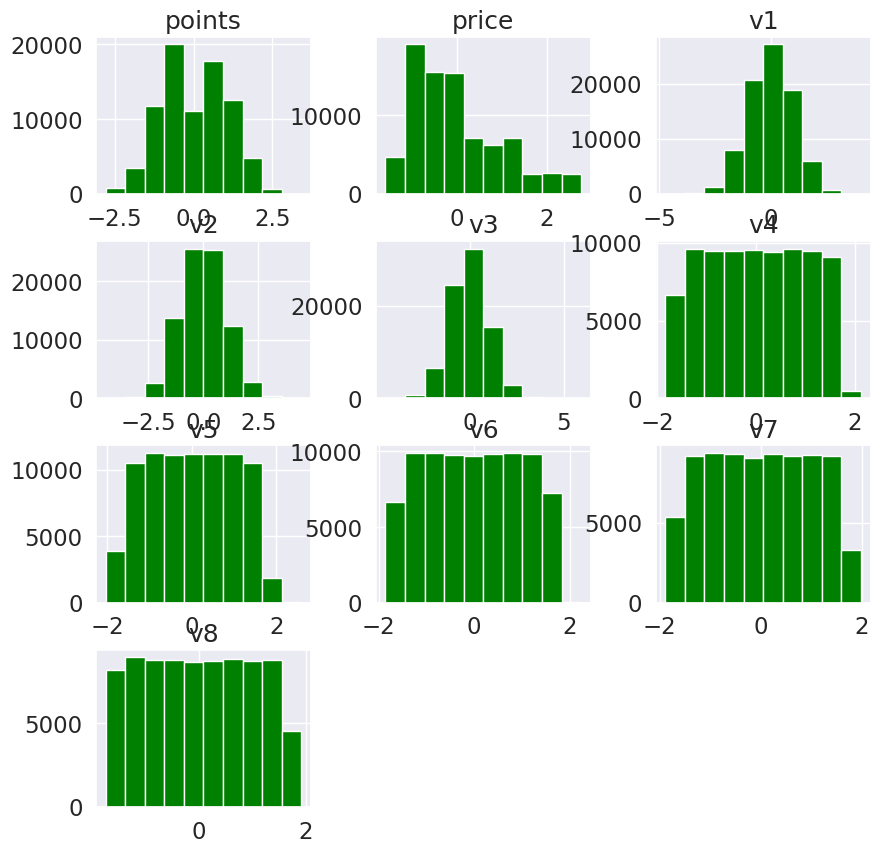

In [43]:
sns.set(font_scale=1.5, rc={'figure.figsize':(10,10)})

ax=data_scaled.hist(color='green' )

In [ ]:
Видим, что данные распределены нормально.

In [44]:
print(data_scaled.min(),'\n\n', data_scaled.max())

points   -2.793345
price    -1.606412
v1       -4.731010
v2       -4.437906
v3       -4.460840
v4       -1.841104
v5       -2.038637
v6       -1.855493
v7       -1.888520
v8       -1.749954
dtype: float64 

 points    3.419450
price     2.775879
v1        4.012653
v2        4.457640
v3        5.922450
v4        2.121937
v5        2.591323
v6        2.240178
v7        1.980679
v8        1.910048
dtype: float64


<Axes: >

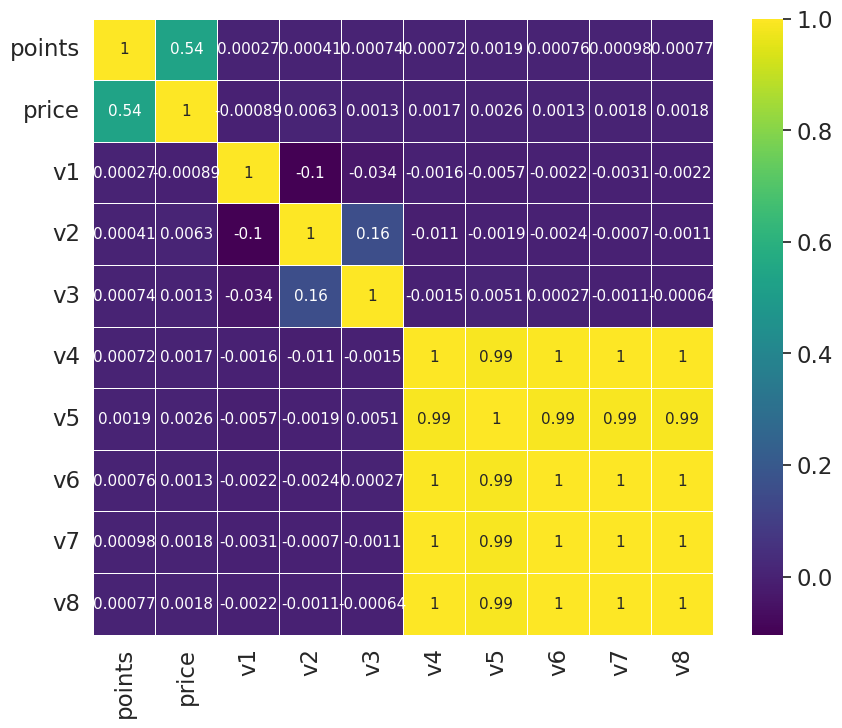

In [45]:
corr = data_scaled.corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

Наблюдаем высокую корреляцию между v5 и v4, v6, v7, v8. Следовательно, можно оставить один из параметров, остальные исключить. Оставляем v5.

In [46]:
# переопределим еще раз датасет, оставив только важное

data_scaled = data_scaled[['points', 'price', "v1","v2","v3","v5"]]

data_scaled.head(3)

,points,price,v1,v2,v3,v5
1,-0.377258,-0.876031,1.597450,0.392163,-0.693135,-1.144204
2,-0.377258,-0.942429,-1.238718,-1.130462,-1.333213,-1.770569
3,-0.377258,-1.008827,0.297905,0.791809,0.339422,1.448697


<Axes: >

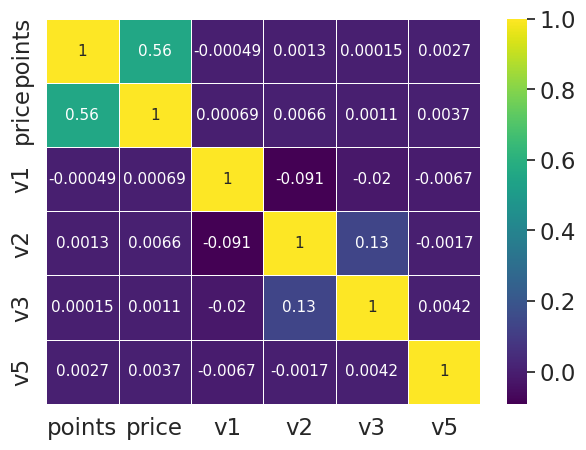

In [47]:
# создадим визуализацию еще раз

corr = data_scaled.corr(method="spearman")

plt.figure(figsize=(7,5))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

In [48]:
from sklearn.decomposition import PCA

pca_2 = PCA(2) # задали количество компонент

pca_2_result = pca_2.fit_transform(data_scaled)

pca_2_result.shape # массив длиной в кол-во строк датасета и шириной по числу компонент

(82776, 2)

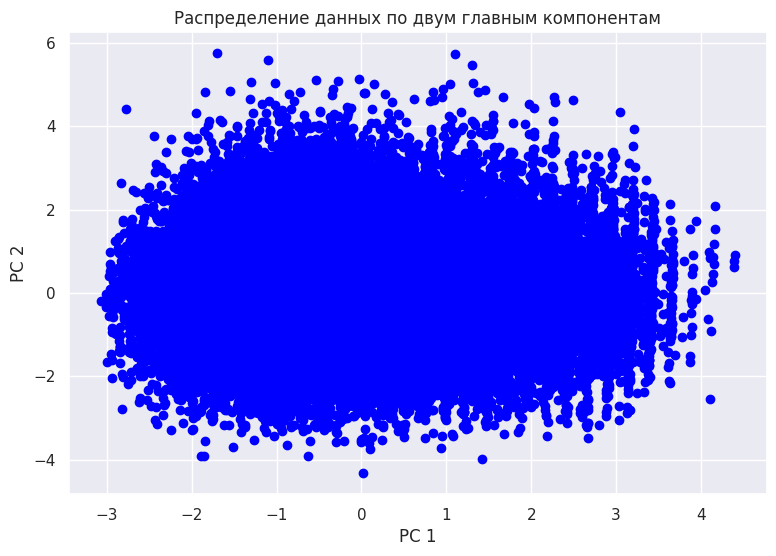

In [49]:
# визуализация распределения данных

sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

## Кластеризация

### K-means (метод k средних)

In [50]:
# определяем число кластеров
import sklearn.cluster as cluster

# inertia = {} # сюда будем сохранять значения
inertia = []
for i in tqdm(range(2,30)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(pca_2_result) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров
    # inertia.update({i:kmeans.inertia_})

# print(inertia)

100%|██████████| 28/28 [02:41<00:00,  5.77s/it]


In [51]:
for i in inertia:
    print(i)

140130.03983913502
95735.76038956943
77676.60877163563
64684.30812701906
53656.98506043668
46900.39589805422
42196.73041990194
37988.68447256119
34361.47921717322
31479.921910678408
29296.392114739305
27246.96065468473
25513.814661924458
23943.685899114964
22486.47127221396
21361.58241329612
20196.330900940695
19286.93209856969
18347.085635500618
17567.138667142408
16762.30017006759
16100.366979591894
15518.519304673526
14923.142913680065
14404.740778401947
13863.725233705638
13458.991534085686
12988.83410671237


In [52]:
from sklearn.metrics import silhouette_score

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_2_result)

    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')

100%|██████████| 18/18 [29:05<00:00, 96.95s/it]


In [53]:
print(silhouette)

{2: 0.3646925059402213, 3: 0.3528295375355133, 4: 0.3222911284298881, 5: 0.31847638785748794, 6: 0.3272343210695811, 7: 0.32006454658287936, 8: 0.31610484477840856, 9: 0.31568095217135195, 10: 0.319917601189709, 11: 0.3182280505610342, 12: 0.3150318911178532, 13: 0.3152494141435996, 14: 0.31491052651665513, 15: 0.31578053187907307, 16: 0.3179391011953079, 17: 0.315508180216527, 18: 0.31499184443598727, 19: 0.31682943134735425}


Text(0.5, 0, 'Число кластеров')

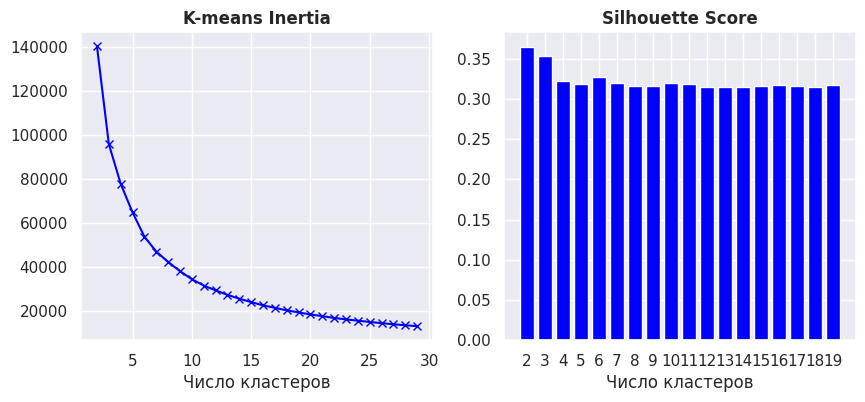

In [54]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')

Выбираем число кластеров равное 3. Число кластеров равное 2 показало хуже результаты по метрике Inertia score (136826), поэтому остановились на k=3.

In [55]:
kmeans = cluster.KMeans(n_clusters=3,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)
# вычисляем центры кластеров и предугадываем номер кластера для каждого семпла данных

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts()) # кол-во вин по кластерам
# kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    31977
2    25607
1    25192
dtype: int64

In [56]:
kmeans_labels

array([0, 0, 2, ..., 2, 2, 0], dtype=int32)

In [57]:
# #  добавим информацию о кластерах в датафрейм
data_scaled['cluster']=kmeans_labels

pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['cluster']=kmeans_labels

In [58]:
# data_scaled
pca_2_df

,0,1,cluster
0,-0.898434,-0.861955,0
1,-0.960641,-1.031228,0
2,-0.961228,0.644505,2
3,1.467705,0.189642,1
4,-0.876667,0.748998,2
...,...,...,...
82771,-1.998807,-0.935220,0
82772,-1.584868,-0.747017,0
82773,-1.694633,1.249185,2
82774,-1.857719,0.592924,2


Было

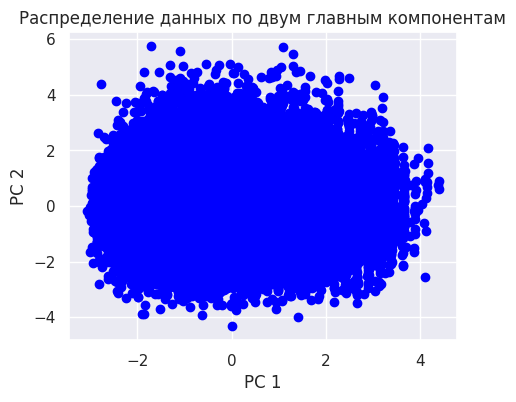

In [59]:
sns.set(rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Стало

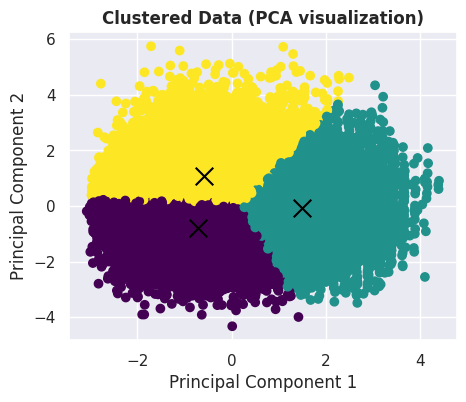

In [60]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

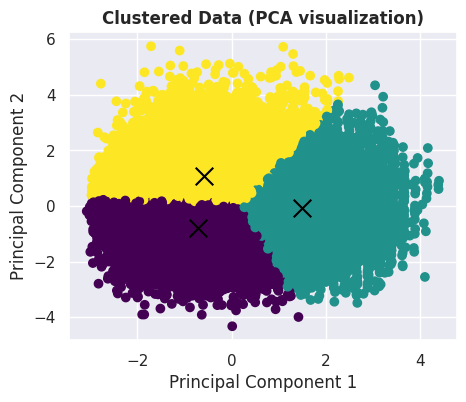

In [61]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

In [62]:
# силуэты: определяется на промежутке [-1;1] (чем выше тем лучше)

# инерция: определяется на [0, inf) (чем ниже тем лучше)

print("Inertia score: %0.1f" % kmeans.inertia_,
     "\nSilhouette score: %0.1f" % silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

Inertia score: 95742.9 
Silhouette score: 0.4


Кажется, что показатели метрик не совсем хорошие, но лучше результата не удалость достичь.

### DBSCAN

In [63]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN,\
                            MeanShift, SpectralClustering

from sklearn import metrics

from sklearn.datasets import make_blobs

In [64]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

X = data_scaled.drop("cluster",axis=1)
cluster = DBSCAN(min_samples=2, eps=0.5)
cluster.fit(X)

DBSCAN(min_samples=2)

In [65]:
data_scaled['cluster'] = cluster.labels_
data_scaled['cluster'].value_counts()

 0       54625
-1       18247
 62         37
 408        24
 1433       20
         ...  
 1714        2
 1715        2
 1716        2
 1717        2
 3603        2
Name: cluster, Length: 3605, dtype: int64

In [66]:
data_scaled['cluster'] = cluster.labels_
data_scaled.groupby(['cluster']).mean()

,points,price,v1,v2,v3,v5
cluster,,,,,,
-1,0.104412,0.476714,-0.048299,0.121087,0.080183,-0.008640
0,-0.074248,-0.262303,0.022862,-0.053893,-0.029850,0.003003
1,-0.377258,2.277891,-0.306502,-0.125826,0.411623,0.956249
2,-0.446289,0.332419,1.370028,-0.878073,-0.849295,0.317314
3,-0.377258,-1.053093,2.188871,-1.394276,0.545468,-0.586960
...,...,...,...,...,...,...
3599,-0.032103,-0.178848,-1.882425,0.255268,-2.350092,-1.102458
3600,-2.448190,-0.544039,-0.335263,-0.306235,-0.749112,-0.869035
3601,-0.722413,-1.174823,-1.706069,-0.735214,-1.733800,1.172936


In [67]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,cluster.labels_ ))

Silhouette Coefficient: -0.567


В этом случае метрика Silhouette Coefficient оказалась еще хуже.

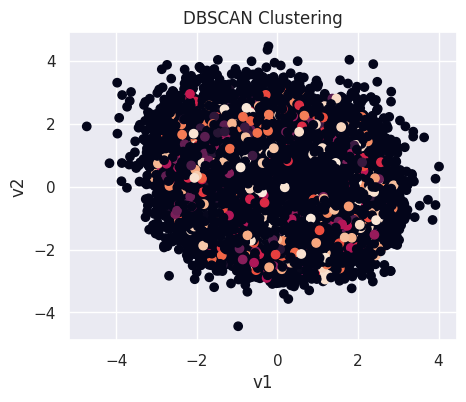

In [75]:
# Визуализация
plt.scatter(data_scaled['v1'], data_scaled['v2'], c=data_scaled['cluster'])
plt.xlabel('v1')
plt.ylabel('v2')
plt.title('DBSCAN Clustering')
plt.show()

Сравнение визуализаций тоже показывает, что K-means сработала лучше.